In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
train_data = np.load('/kaggle/input/distracted-driver/train_statefarm_images.npz')
test_data = np.load('/kaggle/input/distracted-driver/test_statefarm_images.npz')
train_set = torch.tensor(train_data['X'])
train_targets = torch.tensor(train_data['y'])
test_set = torch.tensor(test_data['X'])
test_targets = torch.tensor(test_data['y'])
print("Train set: ", train_set.shape)
print("Test set: ", test_set.shape)
print("Train targets: ", train_targets.shape)
print("Test targets: ", test_targets.shape)

Train set:  torch.Size([17939, 64, 64, 3])
Test set:  torch.Size([4485, 64, 64, 3])
Train targets:  torch.Size([17939])
Test targets:  torch.Size([4485])


In [4]:
from sklearn.model_selection import train_test_split

# Combine train and test data
X_combined = torch.cat([train_set, test_set], dim=0)
y_combined = torch.cat([train_targets, test_targets], dim=0)

print(f"\nCombined data shape: {X_combined.shape}")
print(f"Combined targets shape: {y_combined.shape}")

# Convert to numpy for stratified split
X_combined_np = X_combined.to('cpu').numpy()
y_combined_np = y_combined.to('cpu').numpy()

# Create stratified train-test split (80-20)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_combined_np, 
    y_combined_np, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_combined_np
)

# Convert back to torch tensors
train_set = torch.from_numpy(X_train_new).to(device)
test_set = torch.from_numpy(X_test_new).to(device)
train_targets = torch.from_numpy(y_train_new).to(device)
test_targets = torch.from_numpy(y_test_new).to(device)

print(f"\nNew train set shape: {train_set.shape}")
print(f"New test set shape: {test_set.shape}")
print(f"New train targets shape: {train_targets.shape}")
print(f"New test targets shape: {test_targets.shape}")


Combined data shape: torch.Size([22424, 64, 64, 3])
Combined targets shape: torch.Size([22424])

New train set shape: torch.Size([17939, 64, 64, 3])
New test set shape: torch.Size([4485, 64, 64, 3])
New train targets shape: torch.Size([17939])
New test targets shape: torch.Size([4485])


In [5]:
train_set = train_set.permute(0,3,1,2)
train_set = train_set.to(device)
test_set = test_set.permute(0,3,1,2)
test_set = test_set.to(device)

print(train_set.shape)
print(test_set.shape)

torch.Size([17939, 3, 64, 64])
torch.Size([4485, 3, 64, 64])


In [6]:
class CNNEncoder(nn.Module):
    def __init__(self, block_dim = 32):
        super(CNNEncoder, self).__init__()
        self.block_dim = block_dim
        self.conv_1 = nn.Conv2d(3, 32, 5, stride = 2)
        self.conv_2 = nn.Conv2d(32, 64, 5, stride = 3)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.5)
        self.fc_1 = nn.Linear(64*4*4, 512)

    def forward(self, x):
        # print(x.shape)
        x = self.dropout(self.gelu(self.conv_1(x)))
        # print(x.shape)
        x = self.gelu(self.conv_2(x))
        # print(x.shape)
        x = x.flatten(1)
        # print(x.shape)
        x = self.dropout(self.fc_1(x))

        return x

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model = 512, nhead = 8):
        super(TransformerBlock, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, batch_first = True)
        self.encoder_block = nn.TransformerEncoder(self.encoder_layer, 6)
        self.fc_op = nn.Linear(512, 10)

    def forward(self, x):
        x = self.encoder_block(x) 
        x = x.mean(dim=1) # x is (B, 256)
        output = self.fc_op(x) # x should be (B, 10)

        return output

In [8]:
class VITBlock(nn.Module):
    def __init__(self):
        super(VITBlock, self).__init__()
        self.cnn_encoder = CNNEncoder()
        self.transformer_block = TransformerBlock()
        self.row_threshold, self.col_threshold = 64, 64
        self.row_low, self.col_low = 0, 0
        self.row_high, self.col_high = 32, 32
        self.temp = torch.empty(4)
        
    def forward(self, x):
        self.temp = []
        count = 0
        while(self.row_high <= self.row_threshold):
            self.col_high = 32
            self.col_low = 0
            while(self.col_high <= self.col_threshold):
                x_temp = self.cnn_encoder(x[:,:,self.row_low:self.row_high, self.col_low:self.col_high]) # x here is (B, 3, 32, 32)
                self.temp.append(x_temp) # x_temp here is (B, 256)
                count += 1
                self.col_high += 32
                self.col_low += 32
            self.row_high += 32
            self.row_low += 32

        self.row_low, self.col_low = 0, 0
        self.row_high, self.col_high = 32, 32
        
        # temp should now ideally contain 4 elements of (B, 256)
        # self.temp  = np.array(self.temp)

        self.temp = torch.stack(self.temp, dim=1)
        # print(self.temp.shape)
        # self.temp = self.temp.unsqueeze(1) # temp should be (B, 1, 256)
        # self.temp = torch.cat(self.temp, dim=1)

        outputs = self.transformer_block(self.temp)

        return outputs

In [9]:
from torch.optim import Adam

# cnn_encoder = CNNEncoder()
# cnn_encoder = cnn_encoder.to(device)
# transformer_block = TransformerBlock()
# transformer_block = transformer_block.to(device)
model = VITBlock()
model = model.to(device)

optimizer = Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-4)

In [10]:
import torch.nn.functional as F

loss_per_epoch = []
test_loss_per_epoch = []

def ffnet_training(epochs, batch_size):
    for epoch in range(epochs):
        model.train()
        overall_loss = 0
        overall_test_loss = 0
        idx = torch.randperm(train_set.size(0))
        epoch_set = train_set[idx]
        epoch_targets = train_targets[idx]
        batch_idx = 0
        test_batch_idx = 0
        for j in range(0, train_set.size(0), batch_size):
            batch_arr = epoch_set[j:j+batch_size] / 255.0
            batch_targets = epoch_targets[j:j+batch_size]
            batch_targets = batch_targets

            optimizer.zero_grad()

            outputs = model(batch_arr)
            loss = F.cross_entropy(outputs, batch_targets, reduction = 'mean')
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            batch_idx += 1

        model.eval()
        with torch.no_grad():
            for j in range(0, test_set.size(0), batch_size):
                batch_arr = test_set[j:j+batch_size] / 255.0
                batch_targets = test_targets[j:j+batch_size]
                batch_targets = batch_targets

                outputs = model(batch_arr)
                loss = F.cross_entropy(outputs, batch_targets, reduction = 'mean')
                overall_test_loss += loss.item()
                test_batch_idx += 1

        loss_per_epoch.append(overall_loss/batch_idx)
        test_loss_per_epoch.append(overall_test_loss/test_batch_idx)

        if (epoch+1) % 5 == 0:
            print("Epoch {}:".format(epoch+1))
            print("Train loss: {}".format(overall_loss/batch_idx))
            print("Test loss: {}".format(overall_test_loss/test_batch_idx))
            print()

ffnet_training(50, 512)
torch.save(model.state_dict(), "vit_model.pth")

Epoch 5:
Train loss: 1.4088646570841472
Test loss: 1.012964255279965

Epoch 10:
Train loss: 0.49313347041606903
Test loss: 0.2649299105008443

Epoch 15:
Train loss: 0.2259168918761942
Test loss: 0.1311434374915229

Epoch 20:
Train loss: 0.12685572562946212
Test loss: 0.06827058518926303

Epoch 25:
Train loss: 0.17492807977315453
Test loss: 0.06382502325707012

Epoch 30:
Train loss: 0.10602361719227499
Test loss: 0.05446172422832913

Epoch 35:
Train loss: 0.06283283114640249
Test loss: 0.037780497016178236

Epoch 40:
Train loss: 0.04131958374960555
Test loss: 0.041542252318726644

Epoch 45:
Train loss: 0.03701677473468913
Test loss: 0.03868000478380256

Epoch 50:
Train loss: 0.027453850954771042
Test loss: 0.03620720075236426




✅ Overall Accuracy: 99.18%

📊 Per-Class Accuracy:
Class 0: 99.20%  (494/498)
Class 1: 99.78%  (452/453)
Class 2: 99.57%  (462/464)
Class 3: 99.57%  (467/469)
Class 4: 99.35%  (462/465)
Class 5: 98.49%  (456/463)
Class 6: 99.57%  (463/465)
Class 7: 99.25%  (397/400)
Class 8: 98.43%  (376/382)
Class 9: 98.36%  (419/426)


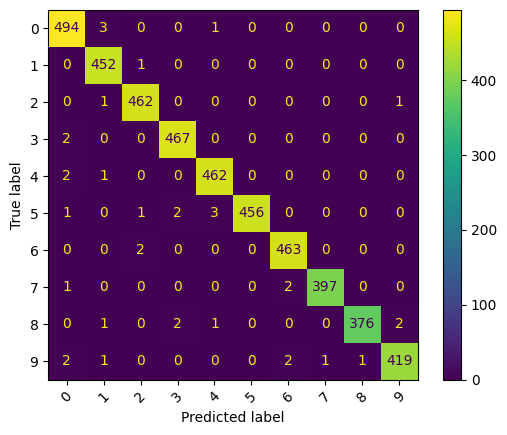

In [11]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_set, test_targets, device='cuda'):
    model.eval()
    n_classes = len(torch.unique(test_targets))
    correct_per_class = [0] * n_classes
    total_per_class = [0] * n_classes
    correct_total = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(0, len(test_set), 128):  # mini-batch eval to save memory
            x_batch = test_set[i:i+128].to(device)
            x_batch = x_batch / 255.0
            y_batch = test_targets[i:i+128].to(device)

            outputs = model(x_batch)
            _, preds = torch.max(outputs, 1)

            correct_total += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            for c in range(n_classes):
                class_mask = (y_batch == c)
                correct_per_class[c] += ((preds == y_batch) & class_mask).sum().item()
                total_per_class[c] += class_mask.sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # overall accuracy
    overall_acc = 100 * correct_total / total
    print(f"\n✅ Overall Accuracy: {overall_acc:.2f}%")

    # per-class accuracy
    print("\n📊 Per-Class Accuracy:")
    for i in range(n_classes):
        acc = 100 * correct_per_class[i] / total_per_class[i]
        print(f"Class {i}: {acc:.2f}%  ({correct_per_class[i]}/{total_per_class[i]})")

    # optional confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(xticks_rotation=45)

# Example usage:
evaluate_model(model, test_set, test_targets, device)

In [12]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Define class labels (StateFarm distracted driver)
CLASS_NAMES = [
    "c0: safe driving",
    "c1: texting - right hand",
    "c2: talking on the phone - right hand",
    "c3: texting - left hand",
    "c4: talking on the phone - left hand",
    "c5: operating the radio",
    "c6: drinking",
    "c7: reaching behind",
    "c8: hair and makeup",
    "c9: talking to passenger"
]

def predict_image(model, image_path, device='cuda', input_size=(224, 224)):
    """
    Run inference on a single image and return the predicted class.
    """

    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),             # Converts to (C,H,W) and scales to [0,1]
    ])

    x = transform(img).unsqueeze(0).to(device)  # Add batch dim

    model.eval()
    with torch.no_grad():
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    print(f"✅ Predicted: {CLASS_NAMES[pred_class]} (class {pred_class})")
    return pred_class, probs.cpu().numpy()

In [13]:
# Assuming your trained model is loaded and on GPU/CPU
image_path = "/path/to/your/test/image.jpg"
predict_image(model, image_path, device='cuda', input_size=(64, 64))

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/your/test/image.jpg'